# Compare HTDemucs Result

In [1]:
# Import Libraries
import torch
import torchaudio
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
from pathlib import Path
import numpy as np

from hdemucs import separate_vocals

import warnings

warnings.filterwarnings("ignore")

In [2]:
use_unproc = False

PROJECT_ROOT = Path().resolve().parent

if use_unproc:
    DATA_DIR = PROJECT_ROOT / "project" / "dataset" / "cadenza_data" / "valid" / "unprocessed"
else:
    DATA_DIR = PROJECT_ROOT / "project" / "dataset" / "cadenza_data" / "valid" / "signals"

RESULTS_DIR = PROJECT_ROOT / "htdemucs" / "results"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
AUDIO_NAME = "1d887341bdf775c49d8a0c30"
suffix = "_unproc" if use_unproc else ""

filename = f"{AUDIO_NAME}{suffix}.flac"

AUDIO_PATH = DATA_DIR / filename

save_fig_path = RESULTS_DIR / f"htdemucs_{AUDIO_NAME}{suffix}_comparison.png"

In [4]:
def show_comparison(original_wav, separated_wav, sr, audio_name, model_name="Demucs", use_unproc=False, save_path=None):
    fig, axes = plt.subplots(3, 2, figsize=(15, 10))
    fig.suptitle(f"Audio Comparison: Original vs {model_name} Vocals", fontsize=16, fontweight="bold")
    
    # Add one subtitle under suptitle
    fig.text(0.5, 0.93, 
             f"Audio Name: {audio_name}{suffix}",
             ha='center', fontsize=12, color='dimgray')

    # Waveform
    axes[0, 0].plot(original_wav[0].numpy(), color='gray')
    axes[0, 0].set_title("Original - Waveform")
    axes[0, 0].set_xlabel("Time (samples)")
    axes[0, 0].set_ylabel("Amplitude")

    axes[0, 1].plot(separated_wav[0].numpy(), color='purple')
    axes[0, 1].set_title(f"{model_name} - Separated Vocals (Waveform)")
    axes[0, 1].set_xlabel("Time (samples)")
    axes[0, 1].set_ylabel("Amplitude")

    # Spectrogram
    spec_orig = librosa.amplitude_to_db(
        torch.abs(torch.stft(original_wav[0], n_fft=1024, hop_length=256, return_complex=True)).numpy(),
        ref=np.max
    )
    spec_voc = librosa.amplitude_to_db(
        torch.abs(torch.stft(separated_wav[0], n_fft=1024, hop_length=256, return_complex=True)).numpy(),
        ref=np.max
    )

    librosa.display.specshow(spec_orig, sr=sr, hop_length=256, x_axis="time", y_axis="hz", ax=axes[1, 0])
    axes[1, 0].set_title("Original - Spectrogram (dB)")
    librosa.display.specshow(spec_voc, sr=sr, hop_length=256, x_axis="time", y_axis="hz", ax=axes[1, 1])
    axes[1, 1].set_title(f"{model_name} - Spectrogram (dB)")

    # MFCC 
    mfcc_orig = librosa.feature.mfcc(y=original_wav[0].numpy(), sr=sr, n_mfcc=13)
    mfcc_voc = librosa.feature.mfcc(y=separated_wav[0].numpy(), sr=sr, n_mfcc=13)

    librosa.display.specshow(mfcc_orig, x_axis="time", sr=sr, ax=axes[2, 0])
    axes[2, 0].set_title("Original - MFCCs")
    librosa.display.specshow(mfcc_voc, x_axis="time", sr=sr, ax=axes[2, 1])
    axes[2, 1].set_title(f"{model_name} - MFCCs")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    # Save Figure locally
    if save_path is not None:
        fig.savefig(save_path, dpi=200)
        print(f"📁 Saved comparison plot to: {save_path}")
        
    plt.show()
    


🎧 Running model: htdemucs
🎧 Using model: htdemucs
Audio path: /Users/reiner/Documents/GitHub/cadenza_2026_submission/project/dataset/cadenza_data/valid/signals/1d887341bdf775c49d8a0c30.flac

▶️ Original Audio:



▶️ Htdemucs Separated:



📁 Saved comparison plot to: /Users/reiner/Documents/GitHub/cadenza_2026_submission/htdemucs/results/htdemucs_1d887341bdf775c49d8a0c30_comparison.png


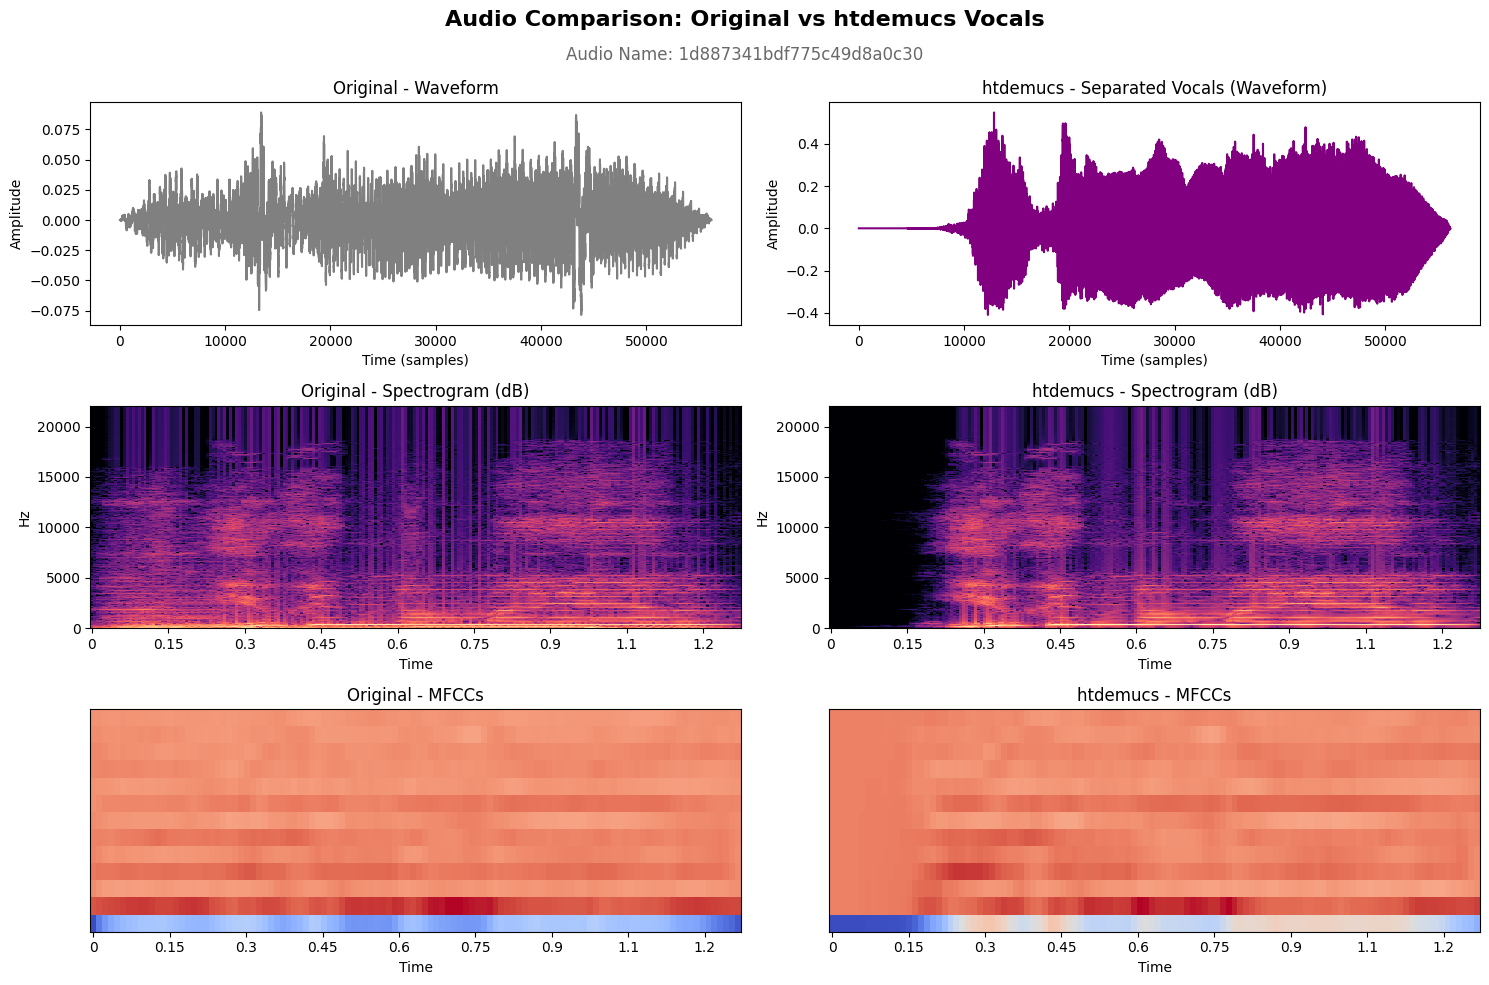

In [5]:
demucs_models = ["htdemucs"]

for model_name in demucs_models:
    print(f"\n🎧 Running model: {model_name}")
    vocals, sr = separate_vocals(str(AUDIO_PATH), model_name=model_name)
    original, _ = torchaudio.load(AUDIO_PATH)

    # Play audio in notebook
    print("▶️ Original Audio:\n")
    display(Audio(original.numpy(), rate=sr))

    print("▶️ Htdemucs Separated:\n")
    display(Audio(vocals[0].numpy(), rate=sr))

    # Show features
    # show_audio_features(vocals, sr, title_prefix=f"{model_name} Vocals")
    show_comparison(original, vocals, sr, AUDIO_NAME, model_name, use_unproc, save_fig_path)

In [6]:
torchaudio.save(f"results/{model_name}_{filename}.wav", vocals, sr)